In [17]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 1.1 MB/s eta 0:01:32
   ---------------------------------------- 0.1/99.8 MB 1.2 MB/s eta 0:01:22
   ---------------------------------------- 0.2/99.8 MB 1.1 MB/s eta 0:01:33
   ---------------------------------------- 0.3/99.8 MB 1.5 MB/s eta 0:01:07
   ---------------------------------------- 0.4/99.8 MB 1.8 MB/s eta 0:00:56
   ---------------------------------------- 0.6/99.8 MB 2.3 MB/s eta 0:00:44
   ---------------------------------------- 1.0/99.8 MB 3.1 MB/s eta 0:00:33
   ---------------------------------------- 1.

In [18]:
import common_functions as cfs

In [19]:
import pandas as pd

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [21]:
import matplotlib.pyplot as plt

In [22]:
from xgboost import XGBClassifier

In [23]:
df = pd.read_csv("bank_churn_train.csv")

In [24]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [26]:
df.Exited.value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

## target variable - Exited
you can observe that classes are imbalanced  
xgboost will handle the  imbalanced dataset 

## Fields analysis 
* Certain fields such as id , surname removing in the first trial as they will not be critical in determining Exited
* Subsequently even CustomerId field can be removed
* Geography is categorical field , will use sci-kit learn preprocessing
* Fields which look important are CreditScore , Age , Tenure , Balance , NumOfProducts , HasCrCard , EstimatedSalary 
  


In [27]:
df.drop(columns =['id','Surname','CustomerId'] , inplace=True)

In [28]:
# extract target column into a numpy array . This would go into fit as argument 
y = cfs.extract_target_column(df,"Exited")
y

array([0, 0, 0, ..., 0, 0, 1])

## find out numerical and catergorical features 
*  use sci-kit learn to handle scaling and pre-processing
*  split training data into training and test data
*  Check how the preprocessing data looks like

In [29]:
numerical_features, categorical_features = cfs.find_cat_num_features(df)

numerical features Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')
categorical features Index(['Geography', 'Gender'], dtype='object')


In [30]:
X_preprocessed , feature_names = cfs.preprocess_dataframe(numerical_features, categorical_features, df)

In [31]:
X_preprocessed_df = pd.DataFrame(data=X_preprocessed, columns=feature_names)

# Display the preprocessed DataFrame
print(X_preprocessed_df)

        num__CreditScore  num__Age  num__Tenure  num__Balance  \
0               0.144135 -0.578074    -0.719973     -0.883163   
1              -0.367706 -0.578074    -1.432694     -0.883163   
2               0.268974  0.211354     1.774548     -0.883163   
3              -0.941966 -0.465299    -1.076334      1.486918   
4               0.743362 -0.578074    -0.007253     -0.883163   
...                  ...       ...          ...           ...   
165029          0.131651 -0.578074    -1.076334     -0.883163   
165030          1.692140 -0.352523    -0.719973     -0.883163   
165031         -1.141708 -0.803625    -0.007253     -0.883163   
165032         -1.279031 -0.916401     0.705467      1.688303   
165033          2.416207 -0.803625    -1.432694     -0.883163   

        num__NumOfProducts  num__HasCrCard  num__IsActiveMember  \
0                 0.814298        0.571263             -0.99555   
1                 0.814298        0.571263              1.00447   
2                 

In [32]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

## Training and prediction 

In [33]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)

# Fit xg_reg to training set
model.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = model.predict(X_test)


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26052
           1       0.74      0.57      0.64      6955

    accuracy                           0.87     33007
   macro avg       0.81      0.76      0.78     33007
weighted avg       0.86      0.87      0.86     33007



In [35]:
confusion_matrix(y_test, y_pred)

array([[24649,  1403],
       [ 3013,  3942]], dtype=int64)

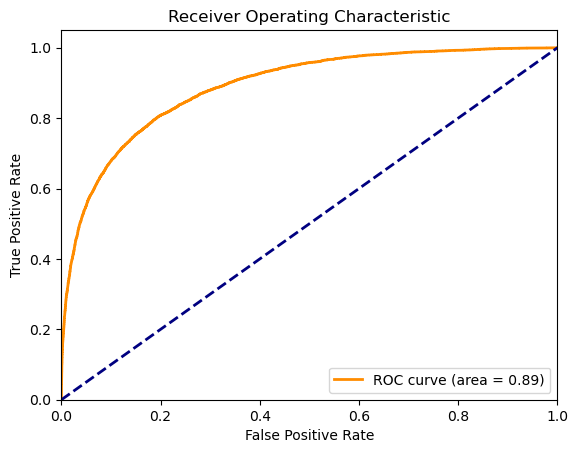

In [38]:
# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

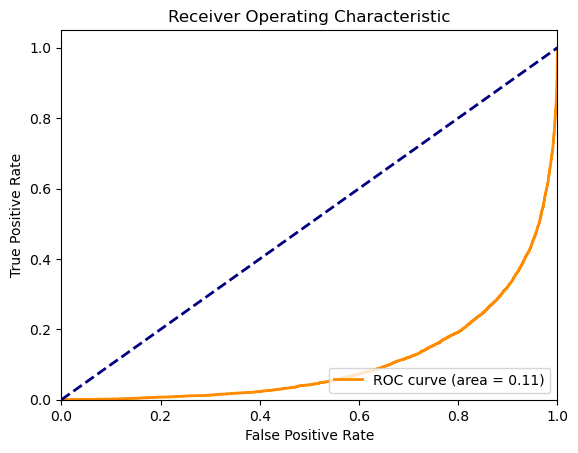

In [46]:
y_probs = model.predict_proba(X_test)[ :, 0]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [42]:
probs = model.predict_proba(X_test)

In [43]:
probs.shape

(33007, 2)

In [49]:
probs[0:3,]

array([[0.84399223, 0.15600774],
       [0.98112994, 0.01887005],
       [0.2966411 , 0.7033589 ]], dtype=float32)

In [51]:
score = recall_score(y_test, y_pred)
print(score)

0.5667864845434939
